## Kaggle Dataset Download

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"1e8e85d548f349b67f2e015da44880bd"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 81% 33.0M/41.0M [00:00<00:00, 37.8MB/s]
100% 41.0M/41.0M [00:00<00:00, 91.4MB/s]


In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/fake-and-real-news-dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Libraries Import

In [ ]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

## Data Preparation and Cleaning

In [ ]:
#reading the csv
fake_news = pd.read_csv('/content/Fake.csv')
real_news = pd.read_csv('/content/True.csv')

In [ ]:
#renaming the columns
fake_news.rename(columns = {'text': 'News', 'title': 'Title'}, inplace = True)
real_news.rename(columns = {'text': 'News', 'title': 'Title'}, inplace = True)

In [ ]:
#adding labels and category
fake_news['label'] = 1
real_news['label'] = 0
fake_news['Category'] = 'Fake'
real_news['Category'] = 'Real'

In [ ]:
#many of the date column's rows contain string type and unwanted data
#keeping only rows that contain actual date
months = ["January", "February","March", "April", "May", "June", "July", "August", "September", "October","November","December"]
pattern = '|'.join(months)

In [ ]:
#removal of unwated and faulty data
fake_news = fake_news[fake_news.date.str.contains(pattern, case=False)]
real_news = real_news[real_news.date.str.contains(pattern, case=False)]

In [ ]:
#converting into standard datetime format
from dateutil import parser
fake_news['date'] = fake_news['date'].apply(lambda x : parser.parse(x))
real_news['date'] = real_news['date'].apply(lambda x : parser.parse(x))

In [ ]:
fake_news.head()

,Title,News,subject,date,label,Category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,Fake


In [ ]:
real_news.head()

,Title,News,subject,date,label,Category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,0,Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,0,Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,0,Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,0,Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,0,Real


## Fake and Real News Dataframe Concatenation

In [ ]:
data = pd.concat([fake_news, real_news], axis=0, ignore_index=True)
data.sample(5)

,Title,News,subject,date,label,Category
6617,The Revolution Won’t Be Beat: Here’s How Sand...,While Bernie Sanders is nowhere near ready to ...,News,2016-04-30,1,Fake
18111,"Trump EPA pick says backs biofuels program, bu...",WASHINGTON (Reuters) - Oklahoma Attorney Gener...,politicsNews,2017-01-18,0,Real
19983,U.S. presidential debate rules out third party...,WASHINGTON (Reuters) - Libertarian Party presi...,politicsNews,2016-09-16,0,Real
6217,Elizabeth Warren HILARIOUSLY Continues Battle...,If you haven t heard about the ongoing battle ...,News,2016-05-23,1,Fake
31719,India Prime Minister Modi inaugurates controve...,MUMBAI (Reuters) - Prime Minister Narendra Mod...,worldnews,2017-09-17,0,Real


In [ ]:
#shuffling the data and resetting the index
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)
data.head()

,Title,News,subject,date,label,Category
0,Asian viewers give nod to Clinton after first ...,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,politicsNews,2016-09-27,0,Real
1,Former U.S. envoys to U.N. warn Congress again...,UNITED NATIONS (Reuters) - Nine former U.S. a...,politicsNews,2017-04-25,0,Real
2,Trump: Father of UCLA player in shoplifting ca...,(Reuters) - U.S. President Donald Trump on Wed...,politicsNews,2017-11-22,0,Real
3,Arm found near Copenhagen could relate to subm...,COPENHAGEN (Reuters) - An unidentified arm fou...,worldnews,2017-11-21,0,Real
4,Bernie Bursts Out Laughing After Trump Unknow...,Hours after helping begin to repeal America s ...,News,2017-05-04,1,Fake


## Target Class Distribution

In [ ]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 80

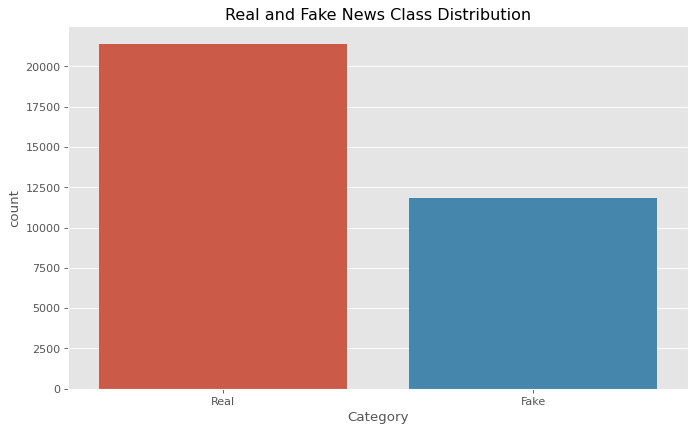

In [ ]:
sns.countplot('Category', data=data)
plt.title('Real and Fake News Class Distribution')
plt.show()

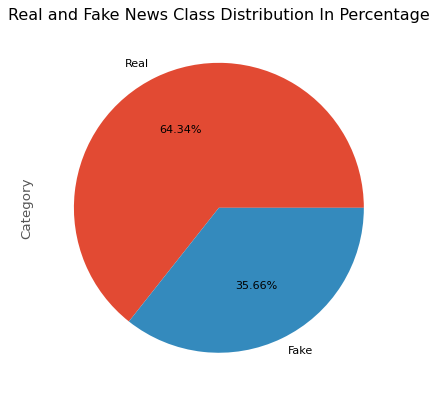

In [ ]:
data['Category'].value_counts().plot.pie(autopct='%1.2f%%')
plt.title('Real and Fake News Class Distribution In Percentage')
plt.show()

## Exploratory Data Analysis

In [ ]:
#droping subject and date column cause we are only going to work with Title and News
data.drop(['subject', 'date'], axis=1, inplace=True)
data.head()

,Title,News,label,Category
0,Asian viewers give nod to Clinton after first ...,BEIJING/TOKYO (Reuters) - Hillary Clinton put ...,0,Real
1,Former U.S. envoys to U.N. warn Congress again...,UNITED NATIONS (Reuters) - Nine former U.S. a...,0,Real
2,Trump: Father of UCLA player in shoplifting ca...,(Reuters) - U.S. President Donald Trump on Wed...,0,Real
3,Arm found near Copenhagen could relate to subm...,COPENHAGEN (Reuters) - An unidentified arm fou...,0,Real
4,Bernie Bursts Out Laughing After Trump Unknow...,Hours after helping begin to repeal America s ...,1,Fake


In [ ]:
def char_counts(x):
  #spliting the words
  s = x.split()
  #joining without space
  x = ''.join(x)
  return len(x)

In [ ]:
#adding more information for exploratory data analysis
data['Title_Word_Counts'] = data['Title'].apply(lambda x: len(str(x).split()))
data['Title_Char_Counts'] = data['Title'].apply(lambda x: char_counts(str(x)))
data['Title_Avg_Word_Length'] = data['Title_Char_Counts']/data['Title_Word_Counts']
data['Title_Stop_Words_Count'] = data['Title'].apply(lambda x: len([word for word in x.split() if word in stopwords]))
data['Title_Numerics_Count'] = data['Title'].apply(lambda x: len([word for word in x.split() if word.isdigit()]))

In [ ]:
#adding more information for exploratory data analysis
data['News_Word_Counts'] = data['News'].apply(lambda x: len(str(x).split()))
data['News_Char_Counts'] = data['News'].apply(lambda x: char_counts(str(x)))
data['News_Avg_Word_Length'] = data['News_Char_Counts']/data['News_Word_Counts']
data['News_Stop_Words_Count'] = data['News'].apply(lambda x: len([word for word in x.split() if word in stopwords]))
data['News_Numerics_Count'] = data['News'].apply(lambda x: len([word for word in x.split() if word.isdigit()]))

In [ ]:
data.sample(5)

,Title,News,label,Category,Title_Word_Counts,Title_Char_Counts,Title_Avg_Word_Length,Title_Stop_Words_Count,Title_Numerics_Count,News_Word_Counts,News_Char_Counts,News_Avg_Word_Length,News_Stop_Words_Count,News_Numerics_Count
2664,Malaysia says no decision yet on new offers to...,KUALA LUMPUR (Reuters) - Malaysia said on Tues...,0,Real,13,71,5.461538,5,0,271,1650,6.088561,114,2
29775,Abu Dhabi Crown Prince offers condolences to e...,DUBAI (Reuters) - The Crown Prince of Abu Dhab...,0,Real,15,88,5.866667,3,0,104,612,5.884615,34,0
17936,Elderly Voter SHAMES Tom Cotton For Trying To...,Vile GOP Senator Tom Cotton made the mistake o...,1,Fake,15,95,6.333333,0,0,293,1624,5.542662,133,0
10526,Republican lawmakers propose more conservative...,WASHINGTON (Reuters) - Two prominent Republica...,0,Real,7,60,8.571429,1,0,359,2388,6.651811,148,6
21607,Bipartisan Harvard panel recommends hacking sa...,SAN FRANCISCO (Reuters) - A bipartisan Harvard...,0,Real,8,68,8.500000,1,0,443,2944,6.645598,178,0


## Frequency of Fake News in Each Month

In [ ]:
count = []
for i in range(12):
  count.append(fake_news['date'].groupby([fake_news.date.dt.month]).agg('count').iloc[i])

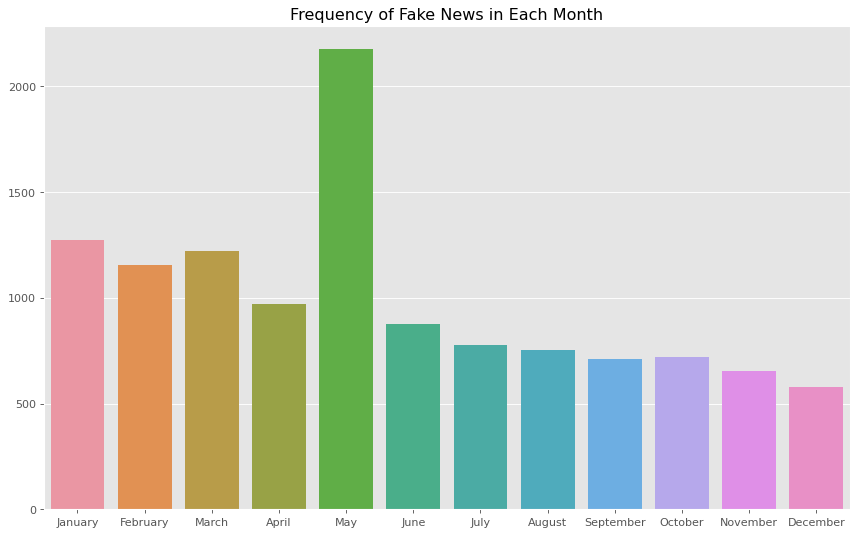

In [ ]:
sns.barplot(x=months,y=count)
plt.title('Frequency of Fake News in Each Month')
plt.rcParams['figure.figsize'] = [13,10]
plt.show()

## Frequency of Real News in Each Month

In [ ]:
count = []
for i in range(12):
  count.append(real_news['date'].groupby([real_news.date.dt.month]).agg('count').iloc[i])

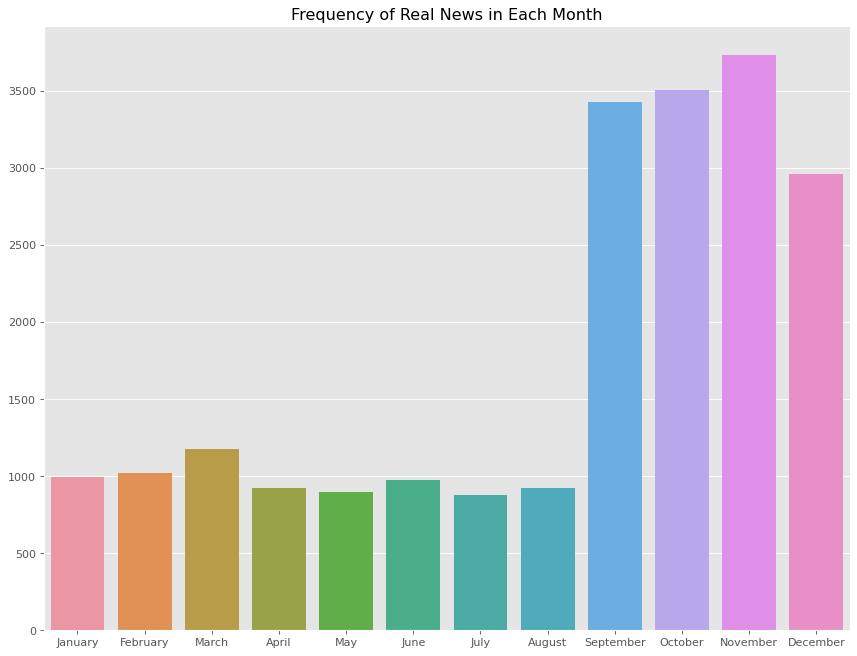

In [ ]:
sns.barplot(x=months,y=count)
plt.title('Frequency of Real News in Each Month')
plt.show()

## Distribution Of Fake News As Per Subjects

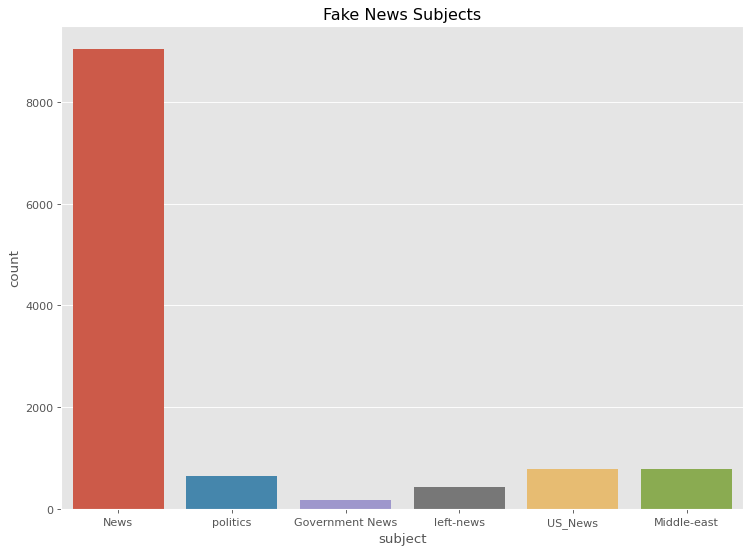

In [ ]:
sns.countplot('subject', data=fake_news)
plt.title('Fake News Subjects')
plt.rcParams['figure.figsize'] = [10,7]
plt.show()

## Distribution Of Real News As Per Subjects

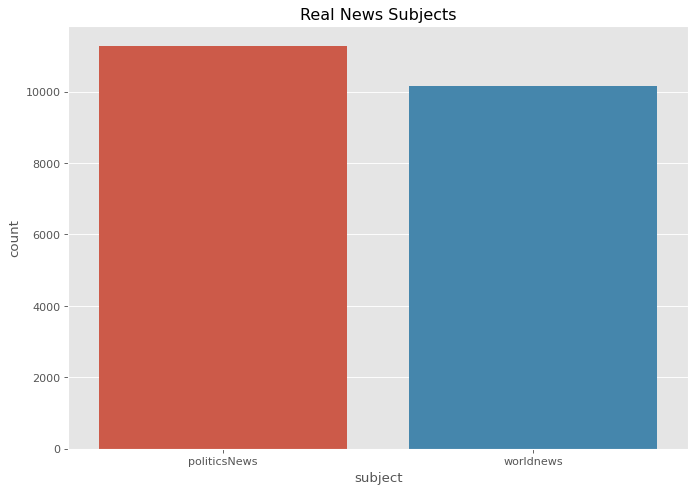

In [ ]:
sns.countplot('subject', data=real_news)
plt.title('Real News Subjects')
plt.show()

## Data Analysis of Fake and Real News Title


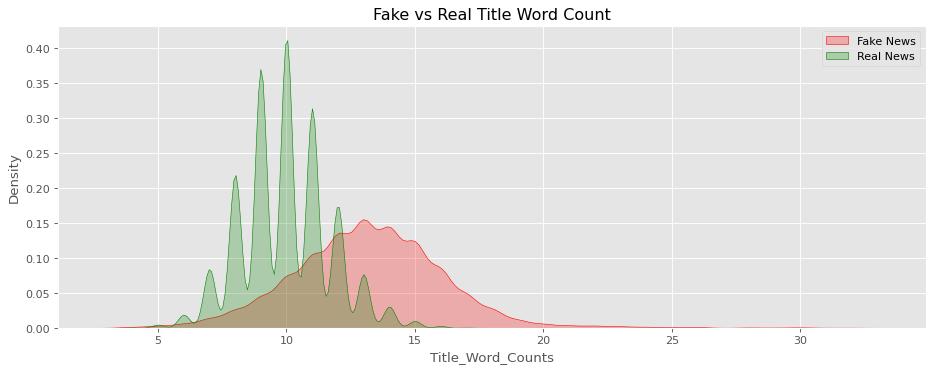

In [ ]:
sns.kdeplot(data[data['label']==1]['Title_Word_Counts'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['Title_Word_Counts'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real Title Word Count')
plt.rcParams["figure.figsize"] = (13,5)
plt.legend()
plt.show()

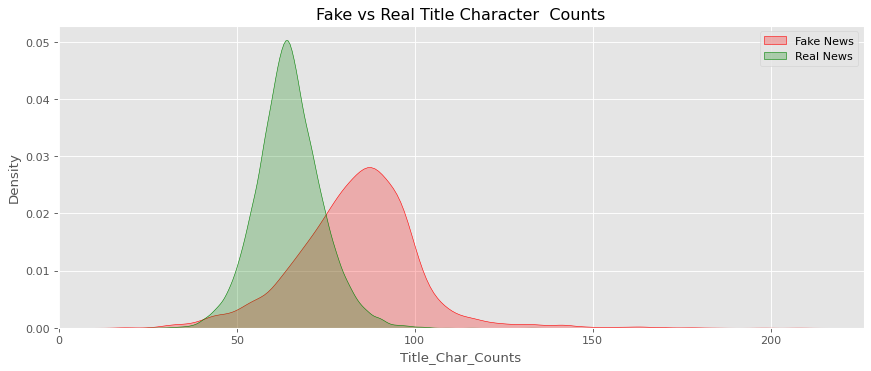

In [ ]:
sns.kdeplot(data[data['label']==1]['Title_Char_Counts'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['Title_Char_Counts'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real Title Character  Counts')
plt.legend()
plt.show()

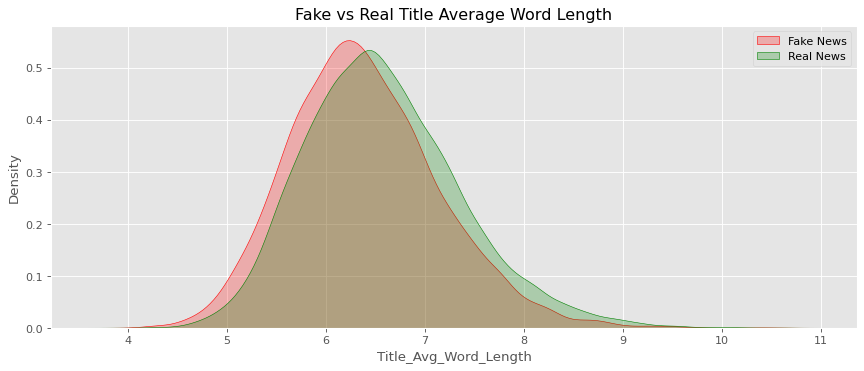

In [ ]:
sns.kdeplot(data[data['label']==1]['Title_Avg_Word_Length'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['Title_Avg_Word_Length'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real Title Average Word Length')
plt.legend()
plt.show()

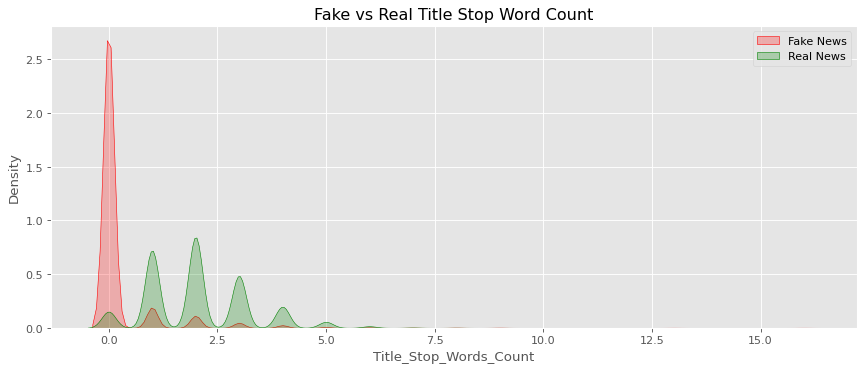

In [ ]:
sns.kdeplot(data[data['label']==1]['Title_Stop_Words_Count'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['Title_Stop_Words_Count'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real Title Stop Word Count')
plt.legend()
plt.show()

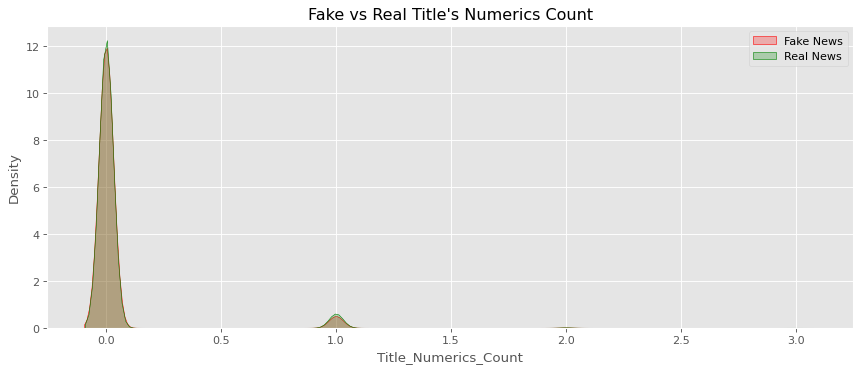

In [ ]:
sns.kdeplot(data[data['label']==1]['Title_Numerics_Count'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['Title_Numerics_Count'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real Title\'s Numerics Count')
plt.legend()
plt.show()

## Data Analysis of Fake and Real News

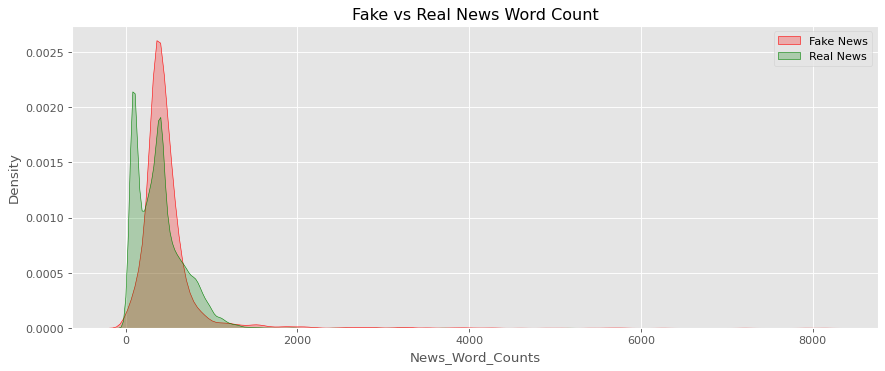

In [ ]:
sns.kdeplot(data[data['label']==1]['News_Word_Counts'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['News_Word_Counts'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real News Word Count')
plt.legend()
plt.show()

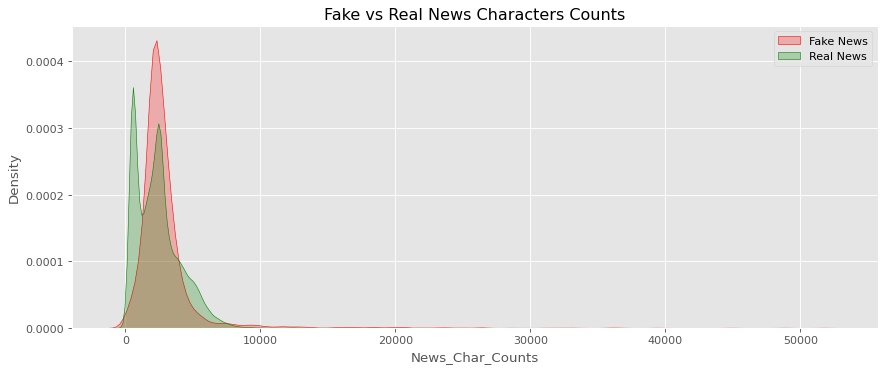

In [ ]:
sns.kdeplot(data[data['label']==1]['News_Char_Counts'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['News_Char_Counts'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real News Characters Counts')
plt.legend()
plt.show()

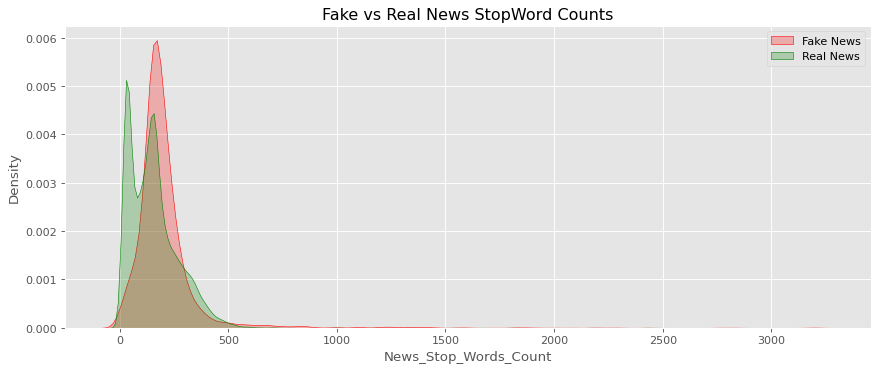

In [ ]:
sns.kdeplot(data[data['label']==1]['News_Stop_Words_Count'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['News_Stop_Words_Count'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real News StopWord Counts')
plt.legend()
plt.show()

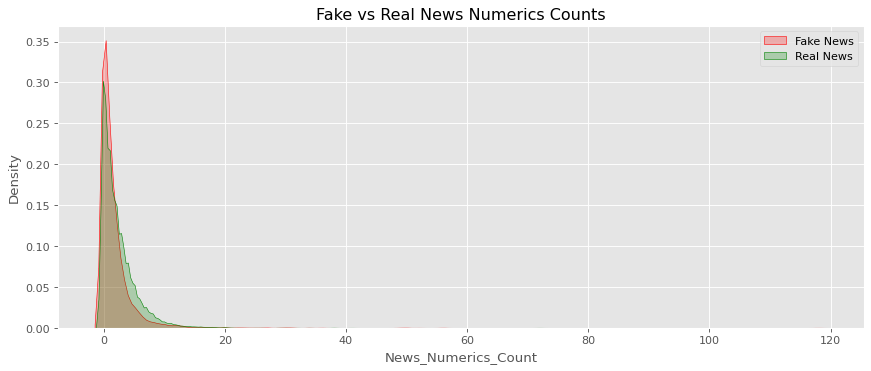

In [ ]:
sns.kdeplot(data[data['label']==1]['News_Numerics_Count'], shade=True, color='r',  label='Fake News')
sns.kdeplot(data[data['label']==0]['News_Numerics_Count'], shade=True, color='g',  label='Real News')
plt.title('Fake vs Real News Numerics Counts')
plt.legend()
plt.show()

## Data Preprocessing & Cleaning

In [ ]:
!pip -q install contractions
import contractions
import unicodedata

     |████████████████████████████████| 266kB 8.5MB/s 
     |████████████████████████████████| 327kB 14.1MB/s 


In [ ]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [ ]:
def get_clean(X):
    X = str(X).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ').replace(':', '')
    X = contractions.fix(X)
    X = X.replace('#', "")
    X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
    X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
    X = re.sub(r'[^\w\d\s]+','', X)
    X = ' '.join(X.split())
    X = BeautifulSoup(X, 'lxml').get_text().strip()
    X = remove_accented(X)
    X = re.sub(r'[^\w ]+','',X)
    X = re.sub("(.)\\1{2,}", "\\1", X)
    X = ' '.join([word for word  in X.split() if word not in  stopwords])
    return X

## Word Cloud Representation For Fake News

In [ ]:
text1_fake_title = ' '.join(data[data['label']==1]['Title'])
text2_fake_news = ' '.join(data[data['label']==1]['News'])

In [ ]:
#combining both title and news column
text_fake = text1_fake_title  + text2_fake_news
#cleaning
text_fake = get_clean(text_fake)
text_fake = text_fake.split()

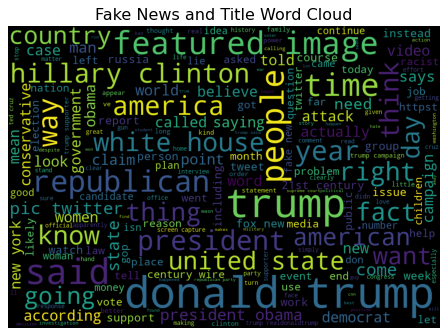

In [ ]:
fake = ' '.join(text_fake)
word_cloud = WordCloud(width=1000, height=700, max_font_size=100).generate(fake)
plt.imshow(word_cloud)
plt.title('Fake News and Title Word Cloud')
plt.axis('off')
plt.show()

## Word Cloud Representation For Real News

In [ ]:
text1_real_title = ' '.join(data[data['label']==0]['Title'])
text2_real_news = ' '.join(data[data['label']==0]['News'])

In [ ]:
#combining both title and news column
text_real = text1_real_title  + text2_real_news
#cleaning
text_real = get_clean(text_real)
text_real = text_real.split()

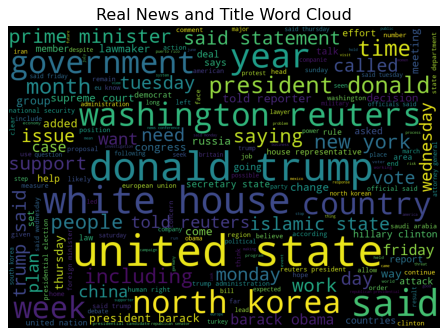

In [ ]:
real = ' '.join(text_real)
word_cloud = WordCloud(width=1000, height=700, max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.title('Real News and Title Word Cloud')
plt.axis('off')
plt.show()

## Data Preparation

In [ ]:
#combining both title and news column
X = data['Title'] + ' ' + data['News']
X_df = pd.DataFrame({'Content':X.values})

In [ ]:
#cleaning
X_df['Content'] = X_df['Content'].apply(lambda x: get_clean(x)) 

In [ ]:
X_df.sample(5)

,Content
2701,cnn hold completely makes fun paul ryan rest a...
26243,trump team says elton john performing inaugura...
7167,turkey says s wants use gold trader case impos...
10431,trump taps fed centrist powell lead s central ...
5440,fbis russia investigation took turn terrify tr...


In [ ]:
#getting labels
y = data['label']
y_df = pd.DataFrame({'Label':y.values})
y_df.sample(5)

,Label
24715,1
31546,0
10978,0
26292,1
20783,0


## Text Preprocessing

In [ ]:
#Tokenization
token = Tokenizer()
token.fit_on_texts(X_df['Content'])

In [ ]:
vocab_size = len(token.word_index) + 1
print('The size of vocab:', vocab_size)

The size of vocab: 137512


In [ ]:
encoded_text = token.texts_to_sequences(X_df['Content'])

In [ ]:
max_length = len(X_df['Content'].max()) + 50
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [ ]:
X.shape, y_df.shape

((33285, 2772), (33285, 1))

## Train and Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df, test_size=0.2, random_state=0, stratify=y)

## Model Building

In [ ]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 2772, 100)         13751200  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2771, 32)          6432      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1385, 32)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1385, 32)          0         
_________________________________________________________________
dense_27 (Dense)             (None, 1385, 32)          1056      
_________________________________________________________________
dropout_19 (Dropout)         (None, 1385, 32)          0         
_________________________________________________________________
dense_28 (Dense)             (None, 1385, 16)         

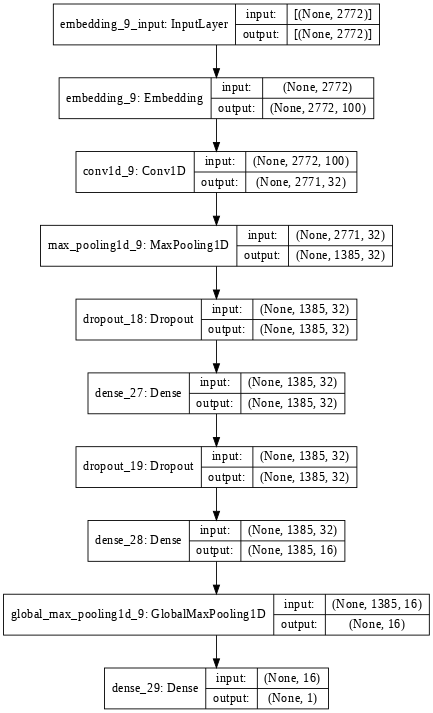

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

## Model Training

In [ ]:
#callback = EarlyStopping(monitor='accuracy', baseline=0.95, patience=0)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
833/833 [==============================] - 129s 153ms/step - loss: 0.2667 - accuracy: 0.8739 - val_loss: 0.0137 - val_accuracy: 0.9962
Epoch 2/2
833/833 [==============================] - 127s 153ms/step - loss: 0.0236 - accuracy: 0.9939 - val_loss: 0.0066 - val_accuracy: 0.9988


## Model Accuracy

In [ ]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The validation accuracy of model is {math.floor(r.history["val_accuracy"][-1] * 100)} %')

The traning accuracy of model is 99 %
The validation accuracy of model is 99 %


## Model Loss

In [ ]:
print(f'The traning loss of model is {r.history["loss"][-1]}')
print(f'The validation loss of model is {r.history["val_loss"][-1]}')

The traning loss of model is 0.02013939432799816
The validation loss of model is 0.006605786737054586


## Model Loss Visualization

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 80

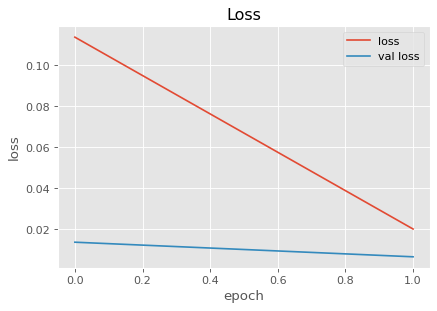

In [ ]:
plt.title('Loss')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

##  Model Accuracy Visualization

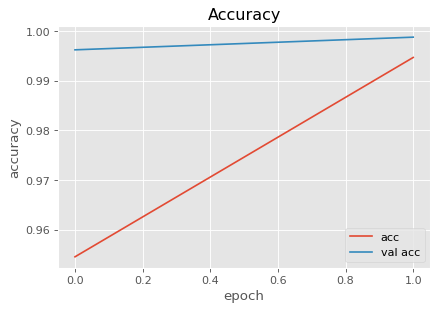

In [ ]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Saving The Model

In [ ]:
model.save('fake_and_real_news_99.h5')

## Making Predictions With Model

In [ ]:
y_pred = model.predict_classes(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
classes = ['Real News', 'Fake News']

In [ ]:
!pip -q install mlxtend

## Confusion Matrix

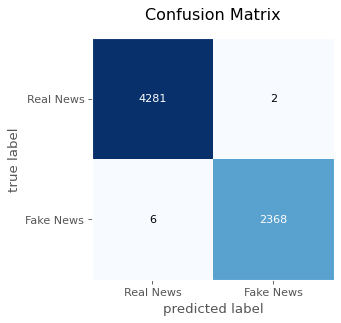

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(cnf_matrix)
ax.set_xticklabels([''] + list(classes))
ax.set_yticklabels([''] + list(classes))
plt.title('Confusion Matrix')
plt.show()
plt.show()

Wow! it classify all fake news correctly with zero error 

## Receiver Operating Characteristics (ROC)

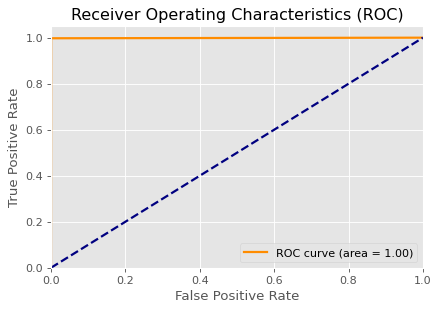

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc="lower right")
plt.show()

## Precision vs. Recall curve

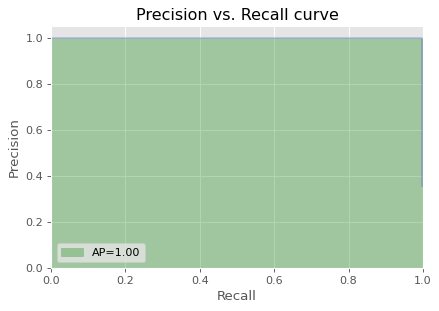

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
average_precision = average_precision_score(y_test, y_pred)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.fill_between(recall, precision, step='post', alpha=0.3, color='g', label='AP={0:0.2f}'.format(average_precision))
plt.title("Precision vs. Recall curve")
#plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="bottom left")
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, y_pred, target_names= ['RealNews', 'FakeNews'], output_dict=True)

In [ ]:
clf = pd.DataFrame(clf_report).iloc[:-1, :].T
clf['precision']['accuracy'] = np.nan
clf['recall']['accuracy'] = np.nan

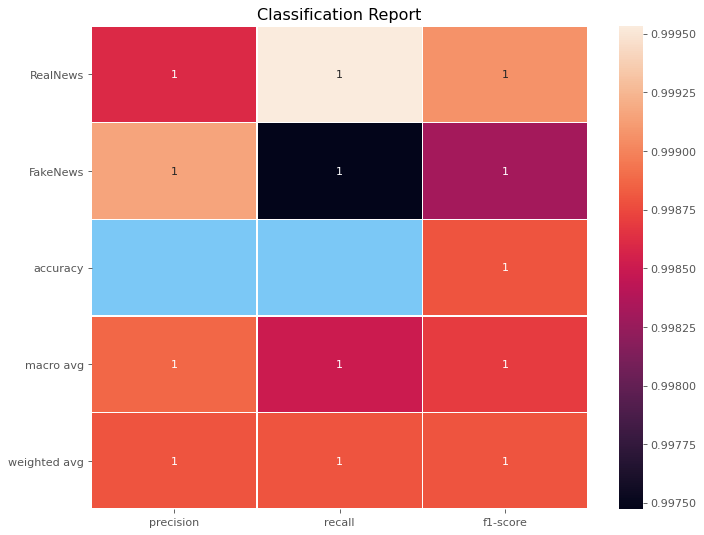

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.heatmap(clf, linewidths=.5, annot=True)
g.set_facecolor('xkcd:lightblue')
plt.yticks(rotation=-0) 
plt.title('Classification Report')
plt.show()

# Testing The Model On Secondary Almost Different Fake News Dataset

## Downloading The Dataset

In [ ]:
! kaggle datasets download -d mrisdal/fake-news

 57% 11.0M/19.4M [00:00<00:00, 106MB/s]
100% 19.4M/19.4M [00:00<00:00, 122MB/s]


In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/fake-news.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Reading The Dataset

This dataset only contain fake news, where the model capability for correctly identifying the fake news which it never sees is going to test.

In [ ]:
fake = pd.read_csv('/content/fake.csv')
fake.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


## Data Preprocessing

In [ ]:
fake['label'] = 1
fake['Category'] = "Fake"
fake = fake[:900]
fake = fake[['title', 'text', 'label', 'Category']]

In [ ]:
print(fake.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     727 non-null    object
 1   text      900 non-null    object
 2   label     900 non-null    int64 
 3   Category  900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.2+ KB
None


In [ ]:
fake = fake.dropna(subset=['title'], how='all')
print(fake.info())
print('\nNew Shape:', fake.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 899
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     727 non-null    object
 1   text      727 non-null    object
 2   label     727 non-null    int64 
 3   Category  727 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.4+ KB
None

New Shape: (727, 4)


In [ ]:
fake_content = fake['title'] + '' + fake['text']
fake_content = pd.DataFrame({'Content':fake_content.values})
fake_content['Content']= fake_content['Content'].astype("string")
print('Shape of Dataframe:',fake_content.shape)
fake_content.head()

Shape of Dataframe: (727, 1)


,Content
0,Muslims BUSTED: They Stole Millions In Gov’t B...
1,Re: Why Did Attorney General Loretta Lynch Ple...
2,BREAKING: Weiner Cooperating With FBI On Hilla...
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...


## Text Cleaning

In [ ]:
fake_content['Content'] = fake_content['Content'].apply(lambda x: get_clean(x)) 
fake_content.sample(5)

,Content
121,tonopah test range google earth imagery 72016t...
529,vatican makes unprecedented agreement chinese ...
523,elon musks true mars earth planhere elon musks...
681,veterans war islamophobiaone veterans war isla...
323,isis executes 300 iraqi civilians firing squad...


## Text Preprocessing

In [ ]:
encoded_text = token.texts_to_sequences(fake_content['Content'])
X_fake = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [ ]:
y_fake = fake['label']
y_fake = pd.DataFrame({'Label':y_fake.values})
y_fake.sample(5)

,Label
671,1
527,1
488,1
677,1
23,1


## Model Evaluation

In [ ]:
results = model.evaluate(X_fake, y_fake)
print('----------------------------------------------------------------------------------------')
print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {} %".format(math.floor(results[1] * 100)))

23/23 [==============================] - 0s 12ms/step - loss: 0.4901 - accuracy: 0.8501
----------------------------------------------------------------------------------------
Test Loss: 0.49005404114723206
Test Accuracy: 85 %


## Model Prediction

In [ ]:
y_fake_pred = model.predict_classes(X_fake)
cnf_matrix = confusion_matrix(y_fake, y_fake_pred)
classes = ['Real News', 'Fake News']

## Confusion Matrix

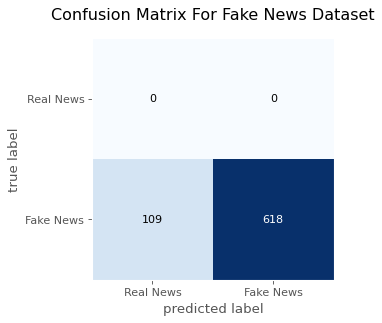

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(cnf_matrix)
ax.set_xticklabels([''] + list(classes))
ax.set_yticklabels([''] + list(classes))
plt.title('Confusion Matrix For Fake News Dataset')
plt.show()
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(y_fake, y_fake_pred, target_names= ['RealNews', 'FakeNews'], output_dict=True)

In [ ]:
clf = pd.DataFrame(clf_report).iloc[:-1, :].T
clf['precision']['accuracy'] = np.nan
clf['recall']['accuracy'] = np.nan

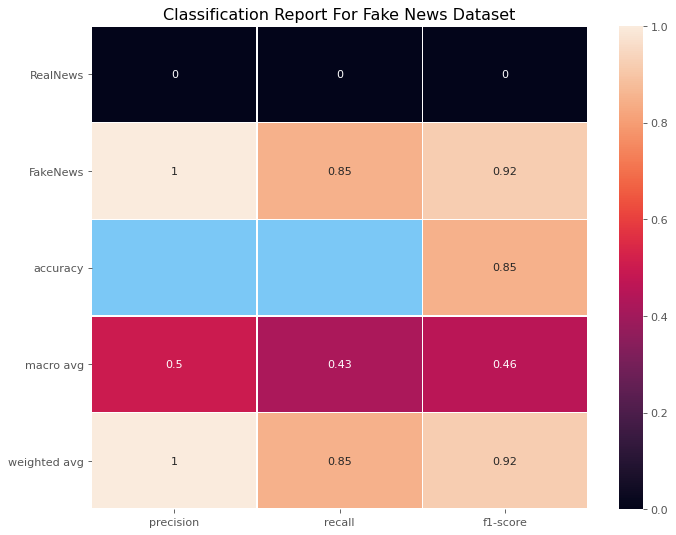

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.heatmap(clf, linewidths=.5, annot=True)
g.set_facecolor('xkcd:lightblue')
plt.yticks(rotation=-0) 
plt.title('Classification Report For Fake News Dataset')
plt.show()